## Problem statement:

## To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing all the important libraries

In [33]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from skimage import io
import os
import glob
import random

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [35]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("Skin cancer ISIC The International Skin Imaging Collaboration/Test")

In [36]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

# Let's load these images off disk using the helpful image_dataset_from_directory utility.


In [38]:

skin_condition_cls = ['actinic keratosis', 'basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']

### Create a dataset

Define some parameters for the loader:

In [40]:
IMAGE_SIZE = 180
BATCH_SIZE = 32
CHANNELS = 3
img_height=IMAGE_SIZE


## Use 80% of the images for training, and 20% for validation.

In [42]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size = (IMAGE_SIZE, IMAGE_SIZE),
  batch_size = BATCH_SIZE)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [43]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(IMAGE_SIZE, IMAGE_SIZE),
  batch_size=BATCH_SIZE)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [44]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

2024-12-17 22:00:48.443141: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


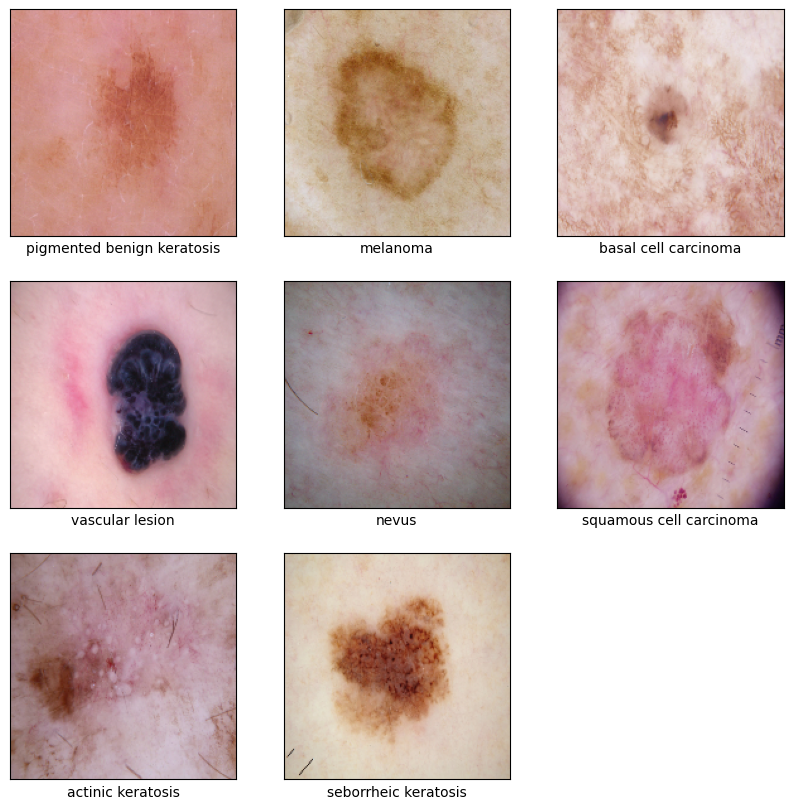

In [46]:
import matplotlib.pyplot as plt
import tensorflow as tf

# Assuming train_ds is your dataset and class_names is defined
# Shuffle the dataset
train_ds = train_ds.shuffle(buffer_size=1000)

# Create a set to track displayed class names
displayed_class_names = set()

plt.figure(figsize=(10, 10))
for image_batch, label_batch in train_ds.take(1):
    unique_images = 0
    for i in range(len(image_batch)):
        if unique_images >= 10:
            break
        class_name = class_names[label_batch[i]]
        if class_name not in displayed_class_names:
            displayed_class_names.add(class_name)
            plt.subplot(3, 3, unique_images + 1)
            plt.imshow(image_batch[i].numpy().astype('uint8'))
            plt.xlabel(class_name)
            plt.xticks([])
            plt.yticks([])
            unique_images += 1
plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [49]:
# globbing example
# help(glob)
DATASET_PATH="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
skin_image_path = os.path.join(DATASET_PATH, skin_condition_cls[1], '*')
print(skin_image_path)

# glob through the directory (returns a list of all file paths)
skin_image_path = glob.glob(skin_image_path)
print(skin_image_path[3]) # access an individual file

Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/*
Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/ISIC_0028568.jpg


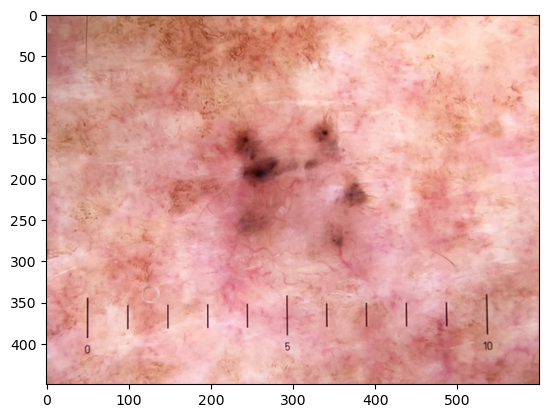

In [50]:
# run this block multiple times to look at some randomly chosen images of roses
rand_index = random.randint(0, len(skin_image_path))
image = io.imread(skin_image_path[rand_index])
plt.imshow(image)

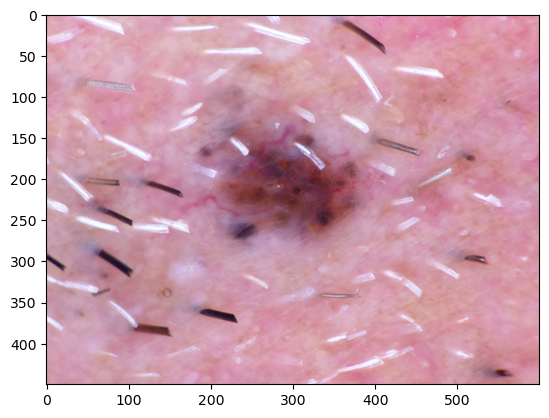

In [51]:
# plot a sample image
skin_image_path = os.path.join(DATASET_PATH, skin_condition_cls[1], '*')
skin_image_path = glob.glob(skin_image_path)

# access some element (a file) from the list
image = io.imread(skin_image_path[5])
plt.imshow(image)

In [52]:
print(image.shape)

(450, 600, 3)


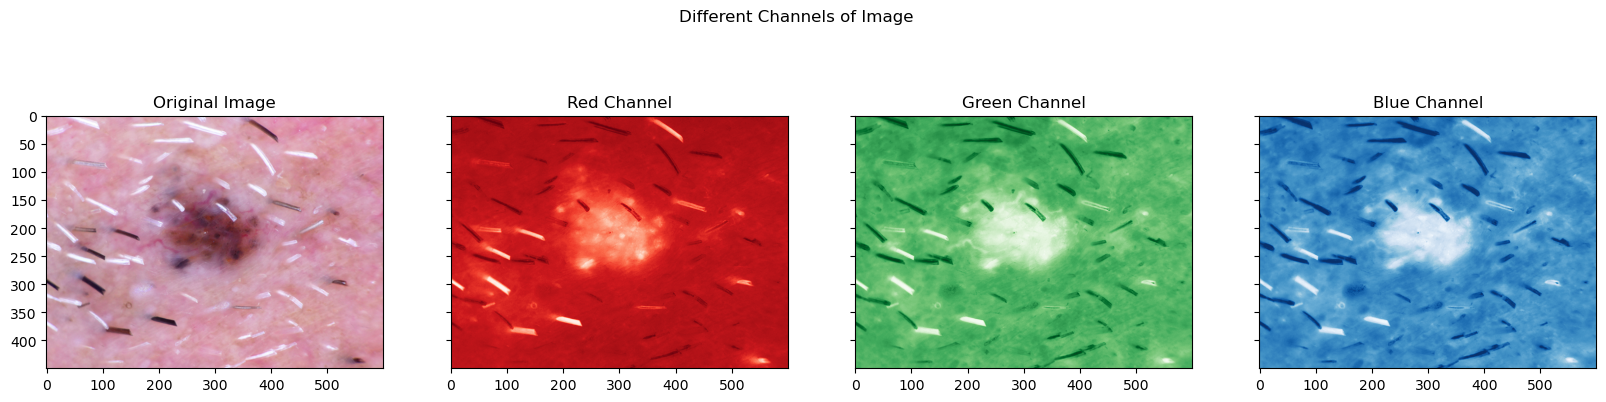

In [53]:
import matplotlib.pyplot as plt

# Assuming 'image' is already defined
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True)
f.set_figwidth(20)

# Original image
ax1.imshow(image)
ax1.set_title('Original Image')

# RGB channels
ax2.imshow(image[:, :, 0], cmap='Reds')
ax2.set_title('Red Channel')

ax3.imshow(image[:, :, 1], cmap='Greens')
ax3.set_title('Green Channel')

ax4.imshow(image[:, :, 2], cmap='Blues')
ax4.set_title('Blue Channel')

f.suptitle('Different Channels of Image')
plt.show()

# Morphological Transformations

## Thresholding
## One of the simpler operations where we take all the pixels whose intensities are above a certain threshold, and convert them to ones; the pixels having value less than the threshold are converted to zero. This results in a binary image.

In [55]:
# function to plot n images using subplots
def plot_image(images, captions=None, cmap=None ):
    f, axes = plt.subplots(1, len(images), sharey=True)
    f.set_figwidth(15)
    for ax,image in zip(axes, images):
        ax.imshow(image, cmap)

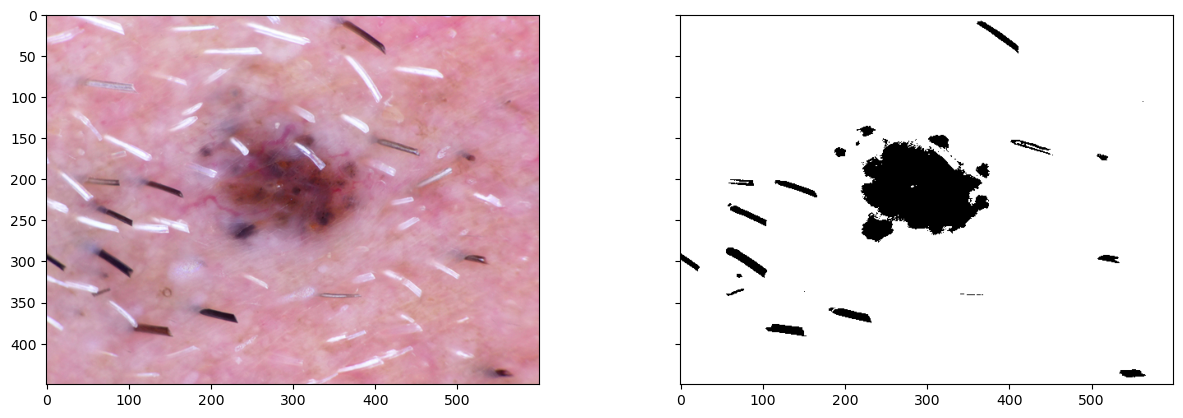

In [56]:
# bin_image will be a (240, 320) True/False array
bin_image = image[:, :, 0] > 150
plot_image([image, bin_image], cmap='gray')

Erosion, Dilation, Opening & Closing
Erosion shrinks bright regions and enlarges dark regions. Dilation on the other hand is exact opposite side - it shrinks dark regions and enlarges the bright regions.

Opening is erosion followed by dilation. Opening can remove small bright spots (i.e. “salt”) and connect small dark cracks. This tends to “open” up (dark) gaps between (bright) features.

Closing is dilation followed by erosion. Closing can remove small dark spots (i.e. “pepper”) and connect small bright cracks. This tends to “close” up (dark) gaps between (bright) features.

All these can be done using the skimage.morphology module. The basic idea is to have a circular disk of a certain size (3 below) move around the image and apply these transformations using it.

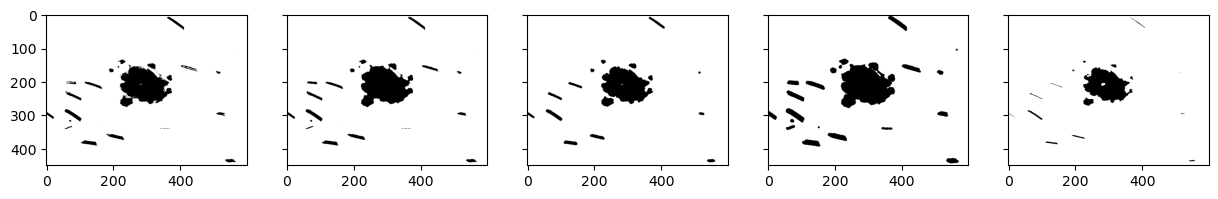

In [58]:
from skimage.morphology import binary_closing, binary_dilation, binary_erosion, binary_opening
from skimage.morphology import disk

# use a disk of radius 3
selem = disk(3)

# oprning and closing
open_img = binary_opening(bin_image, selem)
close_img = binary_closing(bin_image, selem)

# erosion and dilation
eroded_img = binary_erosion(bin_image, selem)
dilated_img = binary_dilation(bin_image, selem)

plot_image([bin_image, open_img, close_img, eroded_img, dilated_img], cmap='gray')

## Normalisation

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


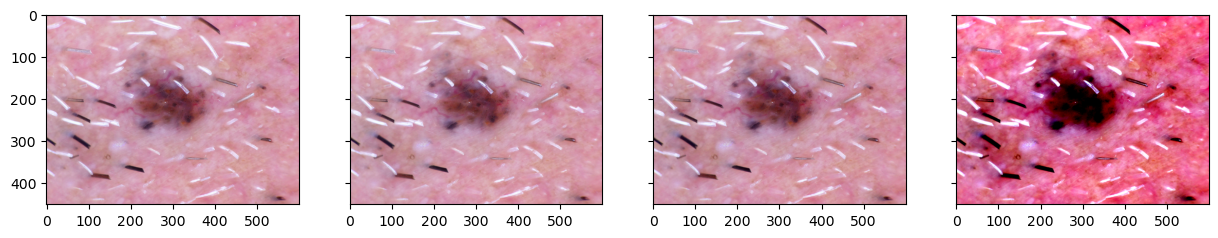

In [60]:
norm1_image = image/255
norm2_image = (image - np.min(image))/(np.max(image) - np.min(image))
norm3_image = (image - np.percentile(image,5))/ (np.percentile(image,95) - np.percentile(image,5))

plot_image([image, norm1_image, norm2_image, norm3_image], cmap='gray')


In [61]:
def scale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0, 1]
    return image, label

In [62]:
# Assuming train_dataset is a tf.data.Dataset
scaled_train_dataset = train_ds.map(scale_image)
scaled_test_dataset = val_ds.map(scale_image)

In [63]:
for image, label in train_ds.take(1):
    print("Image Min:", tf.reduce_min(image).numpy())
    print("Image Max:", tf.reduce_max(image).numpy())

Image Min: 0.0
Image Max: 255.0


2024-12-17 22:00:52.004958: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [64]:
for image, label in val_ds.take(1):
    print("Image Min:", tf.reduce_min(image).numpy())
    print("Image Max:", tf.reduce_max(image).numpy())

Image Min: 0.0
Image Max: 255.0


### Create the model

In [66]:
class_names = ['actinic keratosis', 'basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']
print("Class names:", class_names)
n_classes = len(class_names)


Class names: ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


#  Build the model

In [68]:
BATCH_SIZE=32
IMAGE_SIZE=180
CHANNELS=3

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
IMAGE_SIZE=180
CHANNELS=3

input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Correct input shape
n_classes = len(skin_condition_cls)

# Clear any previous model
tf.keras.backend.clear_session()

# Define the model
model_Base = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Batch normalization after Conv2D
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), 
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.6),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.6), 
    Dense(n_classes, activation='softmax')
])

model_Base.build(input_shape=input_shape)


In [69]:
model_Base.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 89, 89, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 87, 87, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 43, 43, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 41, 41, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 18, 18, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 20736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │    21,234,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,309,737 (81.29 MB)

 Trainable params: 21,309,609 (81.29 MB)

 Non-trainable params: 128 (512.00 B)

### Compile the model

In [71]:
### Todo, choose an appropirate optimiser and loss function

### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
# Save the entire model to a HDF5 file
model_Base.save('model_Base.keras')

optimizer = Adam(learning_rate=0.001)


model_Base.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#
checkpoint_Base = ModelCheckpoint("model_Base.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)


### Train the model

In [73]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# Train the model
epochs = 20
from tensorflow.keras.callbacks import ReduceLROnPlateau


learning_rate_reduction_Base = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

history= model_Base.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs,
                    callbacks=[checkpoint_Base,learning_rate_reduction_Base])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.1749 - loss: 5.0875
Epoch 1: val_accuracy improved from -inf to 0.23043, saving model to model_Base.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 194ms/step - accuracy: 0.1753 - loss: 5.0513 - val_accuracy: 0.2304 - val_loss: 2.1269 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2744 - loss: 1.9432
Epoch 2: val_accuracy did not improve from 0.23043
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 193ms/step - accuracy: 0.2749 - loss: 1.9427 - val_accuracy: 0.1566 - val_loss: 3.5646 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.3505 - loss: 1.7771
Epoch 3: val_accuracy did not improve from 0.23043
56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 191ms/step - accuracy: 0.3510 - loss: 1.7766 - val_accuracy: 0.2170 - val_loss: 10.1947 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step - accuracy: 0.4102 - loss: 1.7263
Epoch 4: val_accuracy improved from 0.230

### Visualizing training results

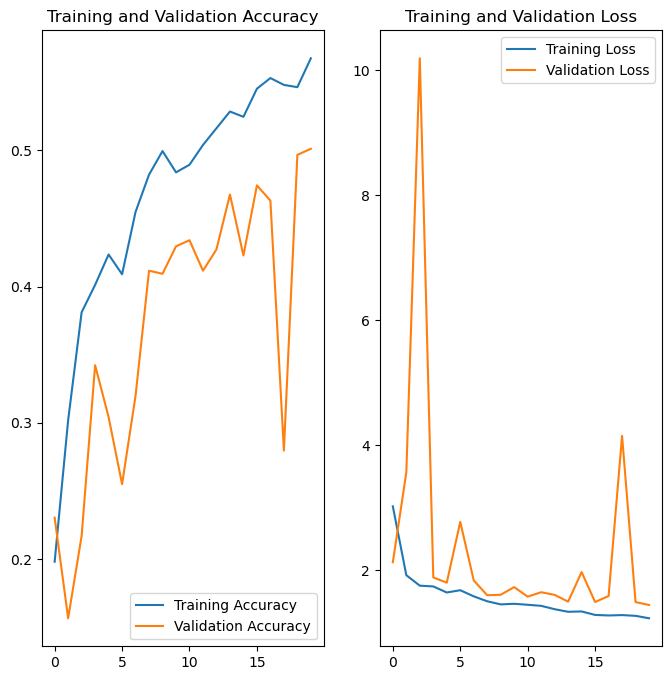

In [75]:
import matplotlib.pyplot as plt

# Extracting the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epochs range based on the length of the accuracy array
epochs_range = range(len(acc))

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

### Training results

In [77]:
loss, accuracy = model_Base.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_Base.evaluate(val_ds, verbose=1)

print("Accuracy            : ", accuracy)
print("Validation Accuracy : ", accuracy_v)
print("Loss                : ", loss)
print("Validation Loss     : ", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.6202 - loss: 1.1517
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.5248 - loss: 1.4218
Accuracy            :  0.6071428656578064
Validation Accuracy :  0.501118540763855
Loss                :  1.158522605895996
Validation Loss     :  1.44270658493042


### This model is definately overfitting and also its not able to achive the higher accuracy due the class imbalance.
### one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.


## Augmentor - To reduce the class imbalance  and increase accuracy

In [80]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the data augmentation
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [81]:
BATCH_SIZE=32
IMAGE_SIZE=180
CHANNELS=3

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Correct input shape
n_classes = len(skin_condition_cls)

# Clear any previous model
tf.keras.backend.clear_session()

# Define the model
model_AUG = Sequential([
    data_augmentation,
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Batch normalization after Conv2D
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)), 
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.6),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.6), 
    Dense(n_classes, activation='softmax')
])

model_AUG.build(input_shape=input_shape)

In [82]:
model_AUG.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)       │ (32, 180, 180, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 89, 89, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 87, 87, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 43, 43, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 41, 41, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 18, 18, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 20736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │    21,234,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,309,737 (81.29 MB)

 Trainable params: 21,309,609 (81.29 MB)

 Non-trainable params: 128 (512.00 B)

## Compile the Model

In [84]:
### Todo, choose an appropirate optimiser and loss function

### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam
# Save the entire model to a HDF5 file
model_AUG.save('model_AUG.keras')

optimizer = Adam(learning_rate=0.001)


model_AUG.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#
checkpoint_AUG = ModelCheckpoint("model_AUG.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)

## Train the Model

In [86]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
# Train the model
epochs = 20
from tensorflow.keras.callbacks import ReduceLROnPlateau


learning_rate_reduction_AUG = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

history= model_AUG.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs,
                    callbacks=[checkpoint_AUG,learning_rate_reduction_AUG])

Epoch 1/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.1699 - loss: 5.5499
Epoch 1: val_accuracy improved from -inf to 0.21700, saving model to model_AUG.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 14s 208ms/step - accuracy: 0.1703 - loss: 5.5091 - val_accuracy: 0.2170 - val_loss: 2.1164 - learning_rate: 0.0010
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step - accuracy: 0.2545 - loss: 2.0369
Epoch 2: val_accuracy improved from 0.21700 to 0.25503, saving model to model_AUG.keras
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 206ms/step - accuracy: 0.2547 - loss: 2.0361 - val_accuracy: 0.2550 - val_loss: 2.0112 - learning_rate: 0.0010
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.3208 - loss: 1.8791
Epoch 3: val_accuracy did not improve from 0.25503
56/56 ━━━━━━━━━━━━━━━━━━━━ 13s 207ms/step - accuracy: 0.3208 - loss: 1.8791 - val_accuracy: 0.2550 - val_loss: 1.9725 - learning_rate: 0.0010
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.2820 - loss: 1.8894
Epoch 

## Visualizing training results

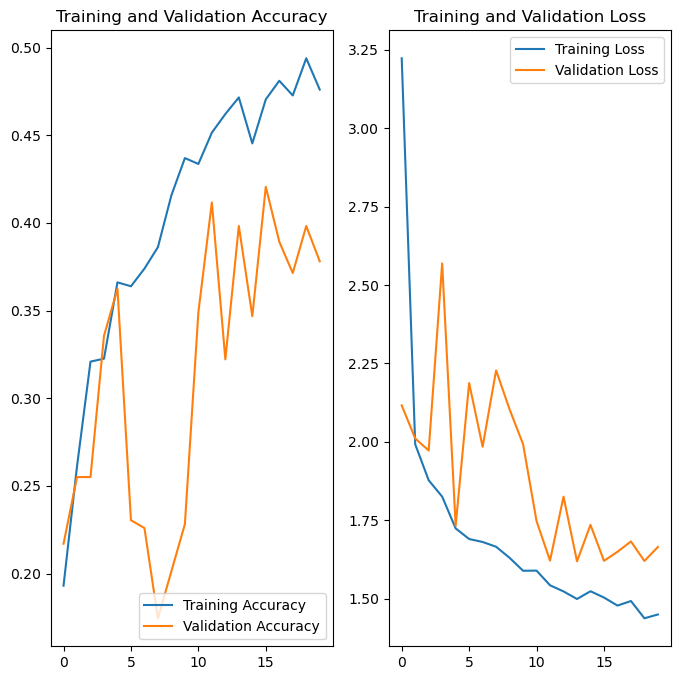

In [88]:
import matplotlib.pyplot as plt

# Extracting the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epochs range based on the length of the accuracy array
epochs_range = range(len(acc))

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

In [89]:
loss, accuracy = model_AUG.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_AUG.evaluate(val_ds, verbose=1)

print("Accuracy            : ", accuracy)
print("Validation Accuracy : ", accuracy_v)
print("Loss                : ", loss)
print("Validation Loss     : ", loss_v)

56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 0.3866 - loss: 1.6391
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.3759 - loss: 1.6281
Accuracy            :  0.3900669515132904
Validation Accuracy :  0.37807607650756836
Loss                :  1.6337798833847046
Validation Loss     :  1.66499924659729


### even though the results  and the graph shows We have reduced the overfitting at certain level by adding Augumentation to the model, But its not able to achive the higher accuracy due the class imbalance.
### one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.


## Augumentation

In [92]:
## Your code goes himport os
from collections import Counter

def analyze_dataset(DATASET_PATH):
    # Initialize a counter to count the number of samples per class
    class_counter = Counter()

    # Iterate over each class folder in the dataset directory
    for class_folder in os.listdir(DATASET_PATH):
        class_folder_path = os.path.join(DATASET_PATH, class_folder)
        
        if os.path.isdir(class_folder_path):
            # Count the number of samples (files) in the class folder
            num_samples = len(os.listdir(class_folder_path))
            class_counter[class_folder] += num_samples

    return class_counter

# Path to the dataset directory
DATASET_PATH = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'

# Analyze the dataset
class_counter = analyze_dataset(DATASET_PATH)

# Class with the least number of samples
least_samples_class = min(class_counter, key=class_counter.get)
least_samples_count = class_counter[least_samples_class]

# Classes dominating the data (highest proportion of samples)
dominant_classes = [cls for cls, count in class_counter.items() if count == max(class_counter.values())]

print(f"Class with the least number of samples: {least_samples_class} ({least_samples_count} samples)")
print("Classes dominating the data:")
for cls in dominant_classes:
    print(f"{cls} ({class_counter[cls]} samples)")

Class with the least number of samples: seborrheic keratosis (77 samples)
Classes dominating the data:
pigmented benign keratosis (462 samples)


### seborrheic keratosis class has the least number of samples - 77 samples
### pigmented benign keratosis  class dominate the data in terms proportionate number of samples - 462 samples



To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [95]:
import Augmentor
import os

path_to_training_dataset = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
class_names = os.listdir(path_to_training_dataset)

for class_name in class_names:
    class_path = os.path.join(path_to_training_dataset, class_name)
    if os.path.isdir(class_path):
        p = Augmentor.Pipeline(class_path)
        p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
        p.sample(2000)  # Adding 2000 samples per class to ensure none of the classes are sparse

Initialised with 438 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x32FE3E240>: 100%|█


Initialised with 462 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 357 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x3024CF2C0>: 100%|█|


Initialised with 376 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


Initialised with 114 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x30086A330>: 100%|█|


Initialised with 181 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x32D11B680>: 100%|█|


Initialised with 139 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x300413740>: 100%|█|


Initialised with 77 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x


Initialised with 95 image(s) found.
Output directory set to Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x3


### Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [97]:
from pathlib import Path

data_dir_train = Path('Skin cancer ISIC The International Skin Imaging Collaboration/Train')
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

18000


### Lets see the distribution of augmented data after adding new images to the original training data.

In [99]:
import glob
import os

data_dir_train = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [100]:
import glob
import os

data_dir_train = 'Skin cancer ISIC The International Skin Imaging Collaboration/Train'
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*', 'output', '*.jpg'))]

In [101]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [103]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
original_df = pd.DataFrame(columns=['Path', 'Label'])
print(original_df)

Empty DataFrame
Columns: [Path, Label]
Index: []


In [104]:
# Concatenate df2 to original_df
new_df = pd.concat([original_df, df2], ignore_index=True)
print(new_df)

                                                    Path           Label
0      Skin cancer ISIC The International Skin Imagin...        melanoma
1      Skin cancer ISIC The International Skin Imagin...        melanoma
2      Skin cancer ISIC The International Skin Imagin...        melanoma
3      Skin cancer ISIC The International Skin Imagin...        melanoma
4      Skin cancer ISIC The International Skin Imagin...        melanoma
...                                                  ...             ...
17995  Skin cancer ISIC The International Skin Imagin...  dermatofibroma
17996  Skin cancer ISIC The International Skin Imagin...  dermatofibroma
17997  Skin cancer ISIC The International Skin Imagin...  dermatofibroma
17998  Skin cancer ISIC The International Skin Imagin...  dermatofibroma
17999  Skin cancer ISIC The International Skin Imagin...  dermatofibroma

[18000 rows x 2 columns]


In [105]:
new_df['Label'].value_counts()

Label
melanoma                      2000
pigmented benign keratosis    2000
nevus                         2000
basal cell carcinoma          2000
actinic keratosis             2000
squamous cell carcinoma       2000
vascular lesion               2000
seborrheic keratosis          2000
dermatofibroma                2000
Name: count, dtype: int64

#### We have added 2000 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

### Train the model on the data created using Augmentor

In [108]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset 80:20 on training data 

In [110]:
data_dir_train="Skin cancer ISIC The International Skin Imaging Collaboration/Train"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 16192 files for training.


#### Create a validation dataset

In [112]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 20239 files belonging to 9 classes.
Using 4047 files for validation.


### Normalization 

In [114]:
def scale_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Scale to [0, 1]
    return image, label

In [115]:
# Assuming train_dataset is a tf.data.Dataset
scaled_train_dataset = train_ds.map(scale_image)
scaled_test_dataset = val_ds.map(scale_image)


In [116]:
for image, label in train_ds.take(1):
    print("Image Min:", tf.reduce_min(image).numpy())
    print("Image Max:", tf.reduce_max(image).numpy())


Image Min: 0.0
Image Max: 255.0


2024-12-17 22:10:35.113894: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [117]:
for image, label in val_ds.take(1):
    print("Image Min:", tf.reduce_min(image).numpy())
    print("Image Max:", tf.reduce_max(image).numpy())

Image Min: 0.0
Image Max: 255.0


#### Build the Model

In [119]:
# AUTOTUNE = tf.data.experimental.AUTOTUNE
# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [120]:
BATCH_SIZE=32
IMAGE_SIZE=180
CHANNELS=3

import tensorflow as tf
from tensorflow.keras.models import Sequential

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)  # Correct input shape
n_classes = len(skin_condition_cls)

# Clear any previous model
tf.keras.backend.clear_session()

# Define the model
model_AG = Sequential([
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    BatchNormalization(),  # Batch normalization after Conv2D
    Dropout(0.4),  # Dropout after pooling layer

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    # BatchNormalization(), 
    Dropout(0.4),

    Conv2D(64, (3, 3), activation='relu'),
    Dropout(0.6),
    
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.6), 
    Dense(n_classes, activation='softmax')
])

model_AG.build(input_shape=input_shape)

In [121]:
model_AG.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (32, 178, 178, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 89, 89, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 89, 89, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 87, 87, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 43, 43, 32)       │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 43, 43, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 41, 41, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (32, 20, 20, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 18, 18, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (32, 18, 18, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 20736)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 1024)             │    21,234,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (32, 1024)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 9)                │         9,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,309,737 (81.29 MB)

 Trainable params: 21,309,609 (81.29 MB)

 Non-trainable params: 128 (512.00 B)

### Compile the Model

In [123]:
### Todo, choose an appropirate optimiser and loss function
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)

# Save the entire model to a HDF5 file
model_AG.save('model_AG.keras')

model_AG.compile(optimizer=optimizer,
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

#
checkpoint_AG = ModelCheckpoint("model_AG.keras",
                             monitor="val_accuracy",
                             save_best_only=True,
                             mode="auto",
                             verbose=1)


## Train the Model

In [125]:
# Train the model
epochs = 50
from tensorflow.keras.callbacks import ReduceLROnPlateau

#The learning rate is reduced by a factor after a specific numbers of epochs. 
# For example, you might start with a learning rate of 0.1 and reduce it by a factor 
# of 0.5 every 10 epochs. This method is simple yet effective, allowing for 
# initial rapid learning that slows down over time.
learning_rate_reduction_AG = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.0001)

history = model_AG.fit(train_ds, 
                    validation_data=val_ds, 
                    epochs=epochs,
                    callbacks=[checkpoint_AG,learning_rate_reduction_AG])

Epoch 1/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.2007 - loss: 2.6653
Epoch 1: val_accuracy improved from -inf to 0.25920, saving model to model_AG.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 103s 201ms/step - accuracy: 0.2008 - loss: 2.6640 - val_accuracy: 0.2592 - val_loss: 1.8653 - learning_rate: 0.0010
Epoch 2/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.3363 - loss: 1.6850
Epoch 2: val_accuracy improved from 0.25920 to 0.33877, saving model to model_AG.keras
506/506 ━━━━━━━━━━━━━━━━━━━━ 101s 199ms/step - accuracy: 0.3363 - loss: 1.6849 - val_accuracy: 0.3388 - val_loss: 1.6923 - learning_rate: 0.0010
Epoch 3/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.3855 - loss: 1.5657
Epoch 3: val_accuracy did not improve from 0.33877
506/506 ━━━━━━━━━━━━━━━━━━━━ 100s 197ms/step - accuracy: 0.3855 - loss: 1.5656 - val_accuracy: 0.2612 - val_loss: 1.9482 - learning_rate: 0.0010
Epoch 4/50
506/506 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step - accuracy: 0.4168 - loss

#### Visualize the model results

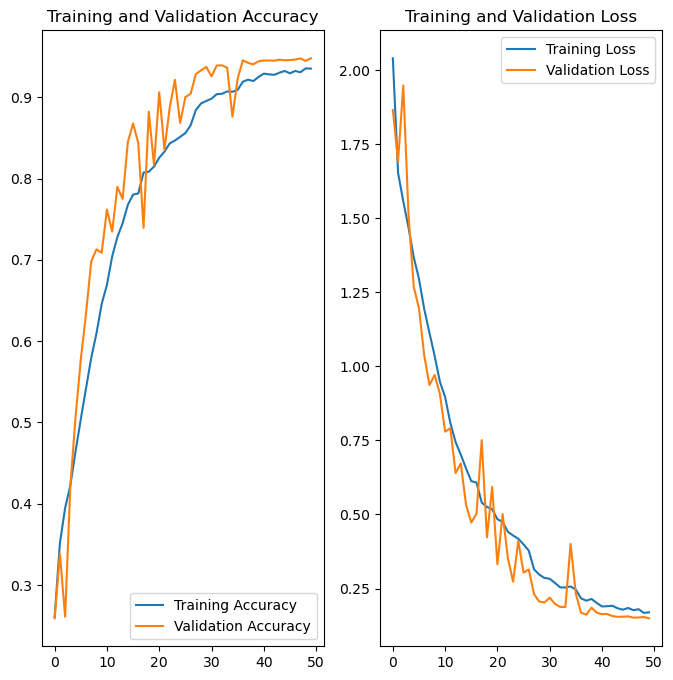

In [127]:
import matplotlib.pyplot as plt

# Extracting the history data
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Generate the epochs range based on the length of the accuracy array
epochs_range = range(len(acc))

# Plotting the training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plotting the training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

plt.show()

## The model is working and providing the great results both on the training and Testing data. The class rebalance activity really helped the model in achieving the accuracy on both Train and Test

In [129]:
loss, accuracy = model_AG.evaluate(train_ds, verbose=1,)
loss_v, accuracy_v = model_AG.evaluate(val_ds, verbose=1)

print("Accuracy            : ", accuracy)
print("Validation Accuracy : ", accuracy_v)
print("Loss                : ", loss)
print("Validation Loss     : ", loss_v)

506/506 ━━━━━━━━━━━━━━━━━━━━ 24s 47ms/step - accuracy: 0.9555 - loss: 0.1127
127/127 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.9432 - loss: 0.1515
Accuracy            :  0.9583745002746582
Validation Accuracy :  0.9478626251220703
Loss                :  0.10799764841794968
Validation Loss     :  0.14956341683864594


## The model seems to be perfect, No overfitting 

## Running the final model on the test data and perform prediction

In [132]:
# path to your dataset
TEST_DATASET_PATH = 'Skin cancer ISIC The International Skin Imaging Collaboration/Test'

skin_condition_cls = ['actinic keratosis', 'basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']

In [133]:
# globbing example
# help(glob)
Skin_details_path = os.path.join(TEST_DATASET_PATH, skin_condition_cls[3], '*')
print(Skin_details_path)

# glob through the directory (returns a list of all file paths)
Skin_details_path = glob.glob(Skin_details_path)
print(Skin_details_path[5]) # access an individual file

Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/*
Skin cancer ISIC The International Skin Imaging Collaboration/Test/melanoma/ISIC_0000035.jpg


### Skin Condition Prediction

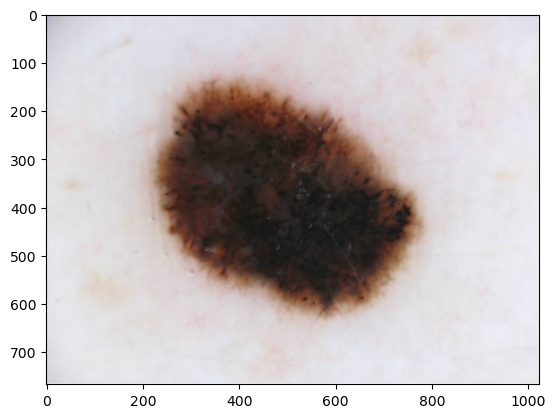

In [135]:
# run this block multiple times to look at some randomly chosen images of skin details
rand_index = random.randint(0, len(Skin_details_path))
image = io.imread(Skin_details_path[rand_index])
plt.imshow(image)

In [136]:
print(image.shape)
# Extracting Image Dimensions
import cv2
h, w, _ = image.shape

# Cropping the Image
img = image[int(h/2)-50:int(h/2)+50, int(w/2)-50:int(w/2)+50, :]

# Resizing the Image to 180x180
resized_img = cv2.resize(img, (180, 180))

# Convert the image to a tensor and ensure it has the correct shape and data type
resized_img_tensor = tf.convert_to_tensor(resized_img, dtype=tf.float32)
resized_img_tensor = tf.expand_dims(resized_img_tensor, axis=0)  # Add batch dimension


(767, 1022, 3)


In [137]:
from tabulate import tabulate
import tensorflow as tf


prediction = model_AG.predict(resized_img_tensor)
# Class labels
skin_condition_cls = ['actinic keratosis', 'basal cell carcinoma','dermatofibroma','melanoma','nevus','pigmented benign keratosis','seborrheic keratosis','squamous cell carcinoma','vascular lesion']

# Get the index of the class with the highest probability
predicted_class_index = tf.argmax(prediction, axis=1).numpy()[0]

# Get the class label
predicted_class_label = skin_condition_cls[predicted_class_index]

# Convert the prediction array to a list or string for tabulation
prediction_probabilities = [float(prob) for prob in prediction[0]]
# Example prediction probabilities (model output)
# prediction_probabilities = [0.1, 0.7, 0.2, 0.05, 0.03, 0.01, 0.02, 0.07, 0.12]  # Example probabilities

# Class labels
skin_condition_cls = [
    'actinic keratosis', 
    'basal cell carcinoma',
    'dermatofibroma',
    'melanoma',
    'nevus',
    'pigmented benign keratosis',
    'seborrheic keratosis',
    'squamous cell carcinoma',
    'vascular lesion'
]

# Combine probabilities with class labels
data = [[i, label, prob] for i, (label, prob) in enumerate(zip(skin_condition_cls, prediction_probabilities))]

# Display data in a tabular format
print(tabulate(data, headers=["Index", "Skin Condition", "Probability"], tablefmt="grid"))

# Prepare data for tabular display
data1 = [
    # ["Actual Prediction Probabilities", prediction_probabilities],
    # ["Class Names", skin_condition_cls],
    ["Predicted Class Index", predicted_class_index],
    ["Predicted Class Label", predicted_class_label]
]

# Display data in a tabular format

print(" ----- The class prediction of the Skin is -----\n")
print(tabulate(data1, headers=["Description", "Value"], tablefmt="grid"))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
+---------+----------------------------+---------------+
|   Index | Skin Condition             |   Probability |
+=========+============================+===============+
|       0 | actinic keratosis          |   7.99667e-12 |
+---------+----------------------------+---------------+
|       1 | basal cell carcinoma       |   8.35192e-10 |
+---------+----------------------------+---------------+
|       2 | dermatofibroma             |   1.02965e-15 |
+---------+----------------------------+---------------+
|       3 | melanoma                   |   0.999022    |
+---------+----------------------------+---------------+
|       4 | nevus                      |   0.000794285 |
+---------+----------------------------+---------------+
|       5 | pigmented benign keratosis |   2.91962e-08 |
+---------+----------------------------+---------------+
|       6 | seborrheic keratosis       |   0.000183332 |
+---------+----------------------------+----------

## Conclusions
1. Model built with class imbalance
   - This model is definately overfitting and also its not able to achive the higher accuracy due the class imbalance.
   - one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality.
2. Using Keras Augumentor  
  - in the conv Layer,even though the results  and the graph shows We have reduced the overfitting at certain level by adding Augumentation to the model,
    but its not able to achive the higher accuracy due the class imbalance.
3. Using Augumented Data - Removed class imbalance
  - model is working and providing the great results both on the training and Testing data. The class rebalance activity really helped the model in achieving the accuracy on both Train and Test


## Results
The model will provide:
1. Predictions for each image, indicating the likelihood of melanoma or other diseases.
2. Metrics evaluating the model’s performance.
3. Model built with data imbalance doesnt achieve the estimated accuracy
4. Model built post implementing Augumentor has produced excellent accuracy.
5. We have tried predicting the model_AG and We can successfully segregate the images and label them with right classification.

## Challenges
1. Imbalanced data distribution may lead to biased predictions.
2. High variability in dermoscopic images (e.g., lighting, angles).